# Setup
Import Tensorflow and helper libraries.

Load google drive folder and files.

#Goals

- Expand dataset w/ variations
- Network also classifies "non cmnist"
- Readd regularization
- Differently sized images
- "black square" cases

In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import re
from PIL import Image

#Saving model in HDF5
!pip install pyyaml h5py
!pip install tensorflowjs
!pip install tensorrt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.14.0


Create the tensorflow dataset with images from data/data and labeling it by the code in the filename.

In [4]:
google_drive_path = '/content/drive/MyDrive/Machine_Learning/Chinese_MNIST/'

# Define a function to extract the label from the filename
def extract_label(file_name):
    match = re.match(r'input_\d+_\d+_(\d+)\.jpg', file_name)
    if match:
        return int(match.group(1))
    else:
        return -1  # Return -1 for invalid filenames

# List all files in the directory
file_names = os.listdir(google_drive_path + 'data/data/')

# Filter out only image files
image_files = [file for file in file_names if file.endswith('.jpg')]

# Create lists to store images and labels
images = []
labels = []

# Load images and extract labels
for file_name in image_files:
    label = extract_label(file_name)
    if label != -1:
        img = load_img(google_drive_path + 'data/data/' + file_name, target_size=(64, 64))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)

# Convert lists to NumPy arrays
images = np.array(images) / 255.0
labels = np.array(labels) - 1

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

#Dilate and contrast the images so that they better match user input
kernel = np.ones((2, 2), np.uint8)

def adjust_contrast(x, factor):
  return tf.image.adjust_contrast(x, factor)

dilate_and_contrast = tf.keras.Sequential([
  layers.Lambda(lambda x: adjust_contrast(x, 3))
])

dataset = dataset.map(
  lambda x, y: (dilate_and_contrast(x), y))

NameError: ignored

In [ ]:
class_names = ['zero', 'one', 'two', 'three', 'four',
               'five', 'six', 'seven', 'eight', 'nine',
               '10', 'bai', 'qian', 'wan', 'yi']


plt.figure(figsize=(10,10))
idx = 0
for image, label in dataset.take(25):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy())
    plt.xlabel(class_names[label.numpy()])
    idx+=1
plt.show()

#Data Augmentation

In [ ]:
augment_data = tf.keras.Sequential([
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.5, fill_mode='constant', fill_value=0.0),
  layers.RandomTranslation(0.2, 0.2, fill_mode='constant', fill_value=0.0)
])

aug_ds = dataset.map(
  lambda x, y: (augment_data(x), y))

In [ ]:
class_names = ['zero', 'one', 'two', 'three', 'four',
               'five', 'six', 'seven', 'eight', 'nine',
               '10', 'bai', 'qian', 'wan', 'yi']

plt.figure(figsize=(10,10))
idx=0
for image, label in aug_ds.take(25):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy())
    plt.xlabel(class_names[label.numpy()])
    idx += 1
plt.show()

In [ ]:
cmnist_dataset = aug_ds.concatenate(dataset)
size = cmnist_dataset.cardinality().numpy()
cmnist_dataset = cmnist_dataset.shuffle(buffer_size=size ,seed=3, reshuffle_each_iteration=False)

del dataset
del aug_ds

In [ ]:
#split the dataset into 80% test, 10% validation, 10% test
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(cmnist_dataset, size)

In [ ]:
#put data into nparrays
train_img_input = np.array([x for x, y in train_ds])
train_label_input = np.array([y for x, y in train_ds])
val_img_input = np.array([x for x, y in val_ds])
val_label_input = np.array([y for x, y in val_ds])
test_img_input = np.array([x for x, y in test_ds])
test_label_input = np.array([y for x, y in test_ds])

Take the split dataset and store it into nparray tensors to be trained in the model.

In [ ]:
#verify the data
print("Training: ")
print(train_img_input.shape)
print(train_label_input.shape)
print(np.max(train_label_input))
print(np.min(train_label_input))
print("Validation: ")
print(val_img_input.shape)
print(val_label_input.shape)
print(np.max(val_label_input))
print("Test: ")
print(test_img_input.shape)
print(test_label_input.shape)
print(np.max(test_label_input))

#check label distribution
distribution = np.zeros(15)
for label in val_label_input:
  distribution[label] += 1
print(distribution)


#plot the data to verify it is correct
class_names = ['zero', 'one', 'two', 'three', 'four',
               'five', 'six', 'seven', 'eight', 'nine',
               '10', 'bai', 'qian', 'wan', 'yi']

plt.figure(figsize=(9,9))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_img_input[2000 + i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[val_label_input[2000 + i]])
plt.show()

Compile the model!

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(80, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(15, kernel_regularizer=tf.keras.regularizers.l2(l=0.1))
])

# Define initial learning rate
initial_learning_rate = 1e-3

# Initialize Adam optimizer with learning rate decay
adam_optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=adam_optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train the model!

In [11]:
#Load model is continuing from a saved point
#model = tf.keras.models.load_model('/content/drive/MyDrive/Machine_Learning/Chinese_MNIST/saved_models/cmnist_best.keras')

In [ ]:
#generator so dataset doesn't take up too much memory

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, x_data, y_data, batch_size):
    self.x, self.y = x_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(x_data) / batch_size)
    self.batch_idx = np.array_split(range(len(x_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_x = self.x[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    return batch_x, batch_y

train_generator = DataGenerator(train_img_input, train_label_input, batch_size = 32)
val_generator = DataGenerator(val_img_input, val_label_input, batch_size = 32)
test_generator = DataGenerator(test_img_input, test_label_input, batch_size = 32)


#Early stopping when validation accuracy stops improving for 3 epochs
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, verbose=1)

#Learning rate decay
decay_rate = 0.5
decay_steps = 1000

# Define learning rate decay function
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay_rate * epoch / decay_steps)

#Model Checkpoint Callback to save the best model
cmnist_path = "/content/drive/MyDrive/Machine_Learning/Chinese_MNIST"
checkpoint_path = os.path.join(cmnist_path, '/saved_models/ckpt', 'cmnist.ckpt')
print(checkpoint_path)

#For saving best model on validation set
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True)

/saved_models/ckpt/cmnist.ckpt


In [ ]:
history = model.fit(train_generator, batch_size=32,validation_data=(val_generator), epochs=5,
          callbacks=[model_checkpoint_callback, LearningRateScheduler(lr_time_based_decay, verbose=1), earlyStop])



Epoch 1: LearningRateScheduler setting learning rate to 0.0009651660220697522.
Epoch 1/5
291/750 [==========>...................] - ETA: 9:17 - loss: 0.4797 - accuracy: 0.9827


KeyboardInterrupt



In [ ]:
#load weights from best Validation accuracy
model.load_weights(checkpoint_path)

model.evaluate(test_img_input,  test_label_input, verbose=2)

model.summary()

94/94 - 36s - loss: 0.4905 - accuracy: 0.9863 - 36s/epoch - 388ms/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 48)        1344      
                                                                 
 batch_normalization (Batch  (None, 62, 62, 48)        192       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        27712     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 30, 30, 64)        256       
 chNormalization)                                

Plot Model Loss and Accuracy

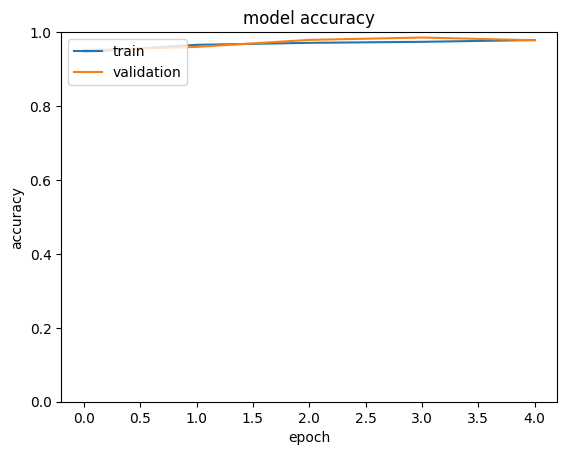

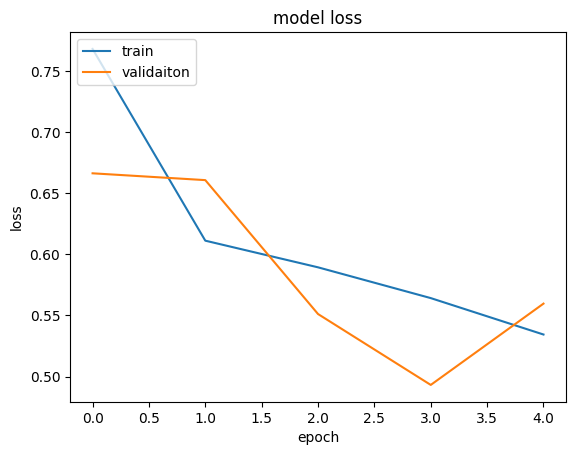

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylim(0, 1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validaiton'], loc='upper left')
plt.show()

In [ ]:
#Save for future use and training
model.save('/content/drive/MyDrive/Machine_Learning/Chinese_MNIST/saved_models/cmnist_best.keras')

# Post Training

Take the trained model and see its predictions on data.

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Machine_Learning/Chinese_MNIST/cmnist_best.keras')

model.evaluate(val_img_input,  val_label_input, verbose=2)

model.summary()

94/94 - 19s - loss: 0.5950 - accuracy: 0.9750 - 19s/epoch - 206ms/step
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_22 (Ba  (None, 62, 62, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_27 (Conv2D)          (None, 60, 60, 48)        13872     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 30, 30, 48)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_23 (Ba  (None, 30, 30, 48)        192       
 tchNormalization)                              

Look at the inaccuracies

1/1 [==============================] - 1s 1s/step
[0.066 0.022 0.004 0.002 0.148 0.031 0.049 0.019 0.029 0.049 0.008 0.209
 0.023 0.208 0.132]


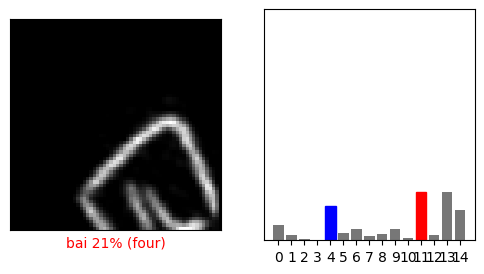

In [ ]:
# https://www.tensorflow.org/tutorials/keras/classification
def plot_image(i, img, predictions_array, true_label):
  true_label= true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(15))
  plt.yticks([])
  thisplot = plt.bar(range(15), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
#edit these to test different images
imgIdx = 240
predictImg = np.expand_dims(val_img_input[imgIdx], axis=0)
inputImg = val_img_input[imgIdx]
label = val_label_input

predictions = probability_model.predict(predictImg)

print(predictions[0])
#plot the image and its scores
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(imgIdx, inputImg, predictions[0], label)
plt.subplot(1,2,2)
plot_value_array(imgIdx, predictions[0], label)
plt.show()

In [ ]:
#Find incorrect predictions
predictions = probability_model.predict(val_img_input)

for i in range(predictions.shape[0]):
  if(np.argmax(predictions[i]) != val_label_input[i]):
      print(i)

94/94 [==============================] - 34s 361ms/step
14
38
95
240
251
314
345
358
380
519
751
827
871
898
940
1011
1022
1042
1168
1292
1353
1397
1402
1471
1500
1563
1600
1631
1633
1659
1697
1814
1882
1954
2013
2093
2167
2198
2243
2250
2376
2485
2512
2555
2576
2618
2648
2778
2887
2924


Convert Model for Website!

In [ ]:
#Convert model for TFJS
model.save('/content/drive/MyDrive/Machine_Learning/Chinese_MNIST/saved_models/cmnist.h5', save_format='h5')

!tensorflowjs_converter --input_format keras \
                       /content/drive/MyDrive/Machine_Learning/Chinese_MNIST/saved_models/cmnist.h5 \
                       /content/drive/MyDrive/Machine_Learning/Chinese_MNIST/saved_models/model

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2023-10-09 23:56:48.731434: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 23:56:48.731519: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 23:56:48.731606: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 23:56:51.582511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
#Get the unregularized version model.json so tfjs can use
unreg_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(80, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(15)
])


# Define initial learning rate
initial_learning_rate = 1e-2

# Initialize Adam optimizer with learning rate decay
adam_optimizer = Adam(learning_rate=initial_learning_rate)

unreg_model.compile(optimizer=adam_optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# No need to fully train since we only need the model.json, not the weights
unreg_model.fit(train_img_input[:1000], train_label_input[:1000], batch_size=32, validation_data=(val_img_input[:1000], val_label_input[:1000]), epochs=1)



32/32 [==============================] - 55s 2s/step - loss: 3.7053 - accuracy: 0.1000 - val_loss: 8.8531 - val_accuracy: 0.0750


In [ ]:
unreg_model.save('/content/drive/MyDrive/Machine_Learning/Chinese_MNIST/saved_models/cmnist_unreg.h5', save_format='h5')

!tensorflowjs_converter --input_format keras \
                       /content/drive/MyDrive/Machine_Learning/Chinese_MNIST/saved_models/cmnist_unreg.h5 \
                       /content/drive/MyDrive/Machine_Learning/Chinese_MNIST/saved_models/model_unreg

2023-10-09 23:58:50.512081: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 23:58:50.512146: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 23:58:50.512192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 23:58:51.878356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
